<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and feature extraction

In this notebook, we import and process the raw experimental data to extract the required features. We then store these into a Pandas dataframe which can be exported to a csv file for future use.

## Importing libraries and loading data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio
import pandas as pd
import modules.utils as tools


In [35]:
import importlib
tools = importlib.reload(tools)

In [5]:
# raw=true is important so you download the file rather than the webpage.
#!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file - we are importing the data for one battery, B0005.
#!mv B0005.mat\?raw\=true B0005.mat
# update scipy
#!pip install -U -q scipy
# Load the data
from scipy import io
import os
datapath = 'Data/'
v = io.loadmat(datapath + 'B0005.mat')

## Preprocessing raw data

### Raw data structure 
The raw battery data (defined as v) is a nested dictionary with keys = ['__header__', '__version__', '__globals__', 'B0005']

In [43]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0006'])

In [6]:
# This extracts the data for all cycles in the form of a nested numpy array.
raw_cycles = np.vstack(v['B0005'][0,0])
type(raw_cycles)

numpy.ndarray

In [7]:
raw_cycles.shape

(1, 616)

In [8]:
# the middle index indicates the charge/discharge number. 
# For example, cycles[0,0][3] gets the data for the first charge, cycles[0,1][3] gets the data for the first discharge, etc.
raw_cycles[0,0][3].shape

(1, 1)

In [10]:
discharge_indices = tools.get_indices(raw_cycles, is_charge = False)
discharge_indices = discharge_indices
print(discharge_indices)
len(discharge_indices)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 135, 139, 143, 147, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 312, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 366, 370, 374, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 482, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 613]


168

In [12]:
charge_indices = tools.get_indices(raw_cycles, is_charge=True)
# manually look through the repeated charge cycle
charge_indices.remove(22)
charge_indices.pop()
print(charge_indices)
len(charge_indices)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 23, 25, 27, 29, 31, 33, 35, 37, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 84, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 134, 137, 141, 145, 148, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 214, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 264, 267, 271, 275, 279, 283, 287, 291, 295, 299, 303, 307, 314, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 431, 434, 438, 442, 446, 450, 454, 458, 462, 466, 470, 474, 478, 481, 483, 486, 490, 494, 498, 502, 506, 510, 514, 518, 522, 526, 530, 534, 538, 542, 546, 549, 553, 557, 561, 565, 569, 573, 577, 581, 585, 589, 593, 597, 601, 605, 609, 612]


168

In [9]:
"This is how you extract all the features from cycles"
#np.vstack(cycles[0,0][3][0,0])[0]

'This is how you extract all the features from cycles'

In [13]:
new_cycles = tools.capacity_vectorizer(discharge_indices, raw_cycles)

In [14]:
new_cycles.shape

(1, 616)

In [16]:
new_cycles[0,1][3][0,0][6].shape

(197,)

## Functions to extract features from original dataset

### Features
#### Discharging cycle

1. Time taken for discharging temperature to reach max value (set threshold ~ 1000s)
2. Max. temperature during discharge
3. Slope for temperature during discharge 
(max_temp - initial_temp)/(time_at_max_temp)
4. Time for voltage_measured to drop below 3 Volts
5. Slope for first 20 data points of voltage_measured

#### Charging cycle

6. Time  taken for charging temperature to reach max value (set threshold ~ 1000s)
7. Max. temperature during charge

### Label
* Capacity recorded for each discharging cycle


## Data Exploration

In [20]:
feature_1_list, feature_2_list = tools.extract_feature_1_2_6_7(discharge_indices, new_cycles)
feature_6_list, feature_7_list = tools.extract_feature_1_2_6_7(charge_indices, new_cycles)
feature_3_list = tools.extract_feature_3(discharge_indices, new_cycles)
feature_4_list = tools.extract_feature_4(new_cycles, discharge_indices)
feature_5_list = tools.extract_feature_5(new_cycles, discharge_indices)
label_list = tools.extract_label(new_cycles, discharge_indices)
remaining_cycles_list = tools.remaining_cycles(new_cycles, discharge_indices, threshold=0.7)

In [21]:
print(remaining_cycles_list)

[160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6, -7]


In [95]:
tools.cycle_plotter(new_cycles,[])

In [22]:
features_dict = {'time_for_max_temp_D':feature_1_list,'max_temp_D':feature_2_list,
                 'slope_temp_D': feature_3_list, 'time_voltage_measured_below3_D':feature_4_list,
                 'slope_voltage_measured_D':feature_5_list, 'time_for_max_temp_C':feature_6_list,
                 'max_temp_C':feature_7_list, 'capacity': label_list, 'remaining_cycles': remaining_cycles_list}

In [23]:
df = pd.DataFrame(data = features_dict)
df

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
0,3366.781,38.982181,0.004352,3287.969,-0.000339,1006.094,27.317609,1.856487,160
1,3348.735,39.033398,0.004281,3269.688,-0.000341,3447.609,29.203048,1.846327,159
2,3329.281,38.818797,0.004231,3250.437,-0.000341,3419.156,29.334557,1.835349,158
3,3329.500,38.762305,0.004237,3250.563,-0.000342,3421.593,29.255008,1.835263,157
4,3327.531,38.665393,0.004250,3248.766,-0.000342,3395.125,29.129995,1.834646,156
...,...,...,...,...,...,...,...,...,...
163,2346.812,40.983663,0.007347,2232.203,-0.000473,1963.141,29.346694,1.293464,-3
164,2327.750,40.982342,0.007380,2222.625,-0.000473,1945.328,29.392476,1.288003,-4
165,2336.282,41.063751,0.007368,2222.094,-0.000474,1916.609,29.451853,1.287453,-5
166,2365.219,41.047030,0.006812,2260.453,-0.000462,1912.391,29.487007,1.309015,-6


In [119]:
#filepath = 'processed_csv/'
#name = 'B0018_processed.csv'
#df.to_csv(filepath+name)

In [24]:
df.describe()

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,2846.875994,39.845110,0.005613,2754.208619,-0.000397,2658.187280,29.456190,1.572502,76.500000
std,342.720870,1.118020,0.001053,362.104457,0.000046,556.328245,0.692348,0.190413,48.641546
min,2327.750000,37.801336,0.004146,2222.094000,-0.000474,1004.344000,23.888926,1.287453,-7.000000
25%,2520.270000,38.804674,0.004540,2408.808500,-0.000439,2174.832000,29.200590,1.390021,34.750000
50%,2818.523500,40.080753,0.005652,2713.586000,-0.000397,2588.718500,29.465142,1.557085,76.500000
75%,3195.621250,40.865238,0.006538,3132.226750,-0.000348,3203.429000,29.827732,1.769163,118.250000
max,3366.781000,41.450232,0.007380,3290.750000,-0.000332,3494.703000,31.187718,1.856487,160.000000


In [25]:
discharge_indices[30]

85

<AxesSubplot:>

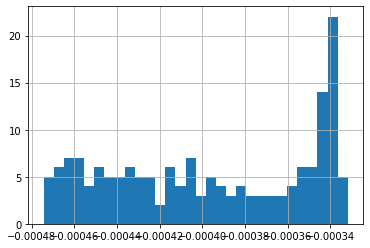

In [26]:
df['slope_voltage_measured_D'].hist(bins=30)

In [27]:
corr_matrix = df.corr()
corr_matrix

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
time_for_max_temp_D,1.000000,-0.933960,-0.994783,0.999710,0.995416,0.878305,-0.508610,0.999813,0.989125
max_temp_D,-0.933960,1.000000,0.921307,-0.937172,-0.926050,-0.851372,0.578307,-0.935272,-0.914857
slope_temp_D,-0.994783,0.921307,1.000000,-0.994703,-0.996371,-0.883042,0.469977,-0.994994,-0.986754
time_voltage_measured_below3_D,0.999710,-0.937172,-0.994703,1.000000,0.995519,0.878788,-0.511434,0.999804,0.987019
slope_voltage_measured_D,0.995416,-0.926050,-0.996371,0.995519,1.000000,0.881756,-0.483197,0.996180,0.984813
time_for_max_temp_C,0.878305,-0.851372,-0.883042,0.878788,0.881756,1.000000,-0.195099,0.878075,0.868575
max_temp_C,-0.508610,0.578307,0.469977,-0.511434,-0.483197,-0.195099,1.000000,-0.510329,-0.473058
capacity,0.999813,-0.935272,-0.994994,0.999804,0.996180,0.878075,-0.510329,1.000000,0.987739
remaining_cycles,0.989125,-0.914857,-0.986754,0.987019,0.984813,0.868575,-0.473058,0.987739,1.000000


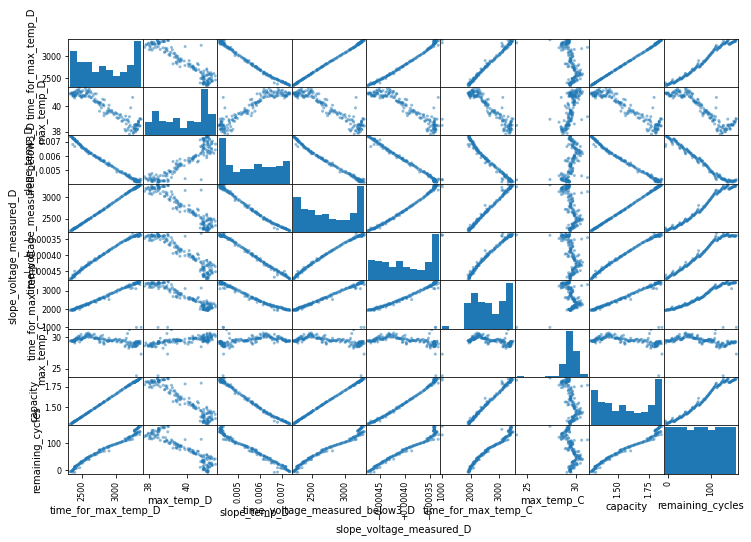

In [28]:
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

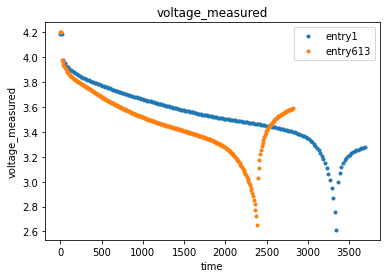

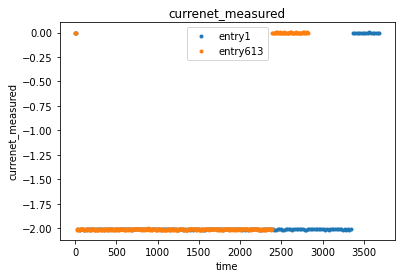

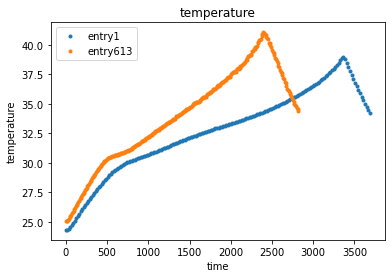

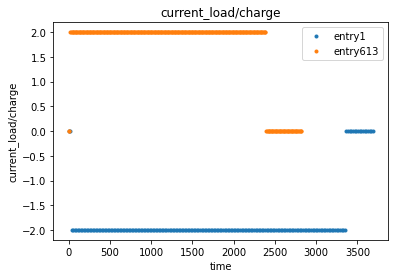

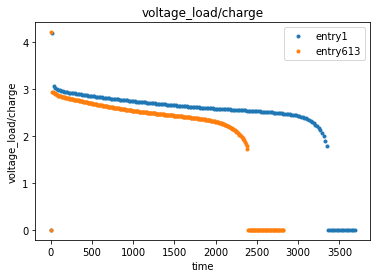

In [36]:
tools.cycle_plotter(new_cycles, [discharge_indices[0], discharge_indices[-1]])